## 卷积神经网络（Convolutional Neural Network, CNN）

## 项目：猫狗大战

### 项目内容

本项目拟采用 keras 结合 tensorflow 作为后端来完成编码。具体流程如下：

* [Step 0](#step0): 数据预处理
* [Step 1](#step1): 搭建模型
* [Step 2](#step2): 模型训练
* [Step 3](#step3): 模型评估
* [Step 4](#step4): 模型可视化

---
<a id='step0'></a>
## 步骤 0: 数据预处理

#### 数据集探索
首先从 Kaggle 网站下载本项目所需的训练集文件 train.zip 和测试集文件 test.zip，分别解压放置于 data 目录下。检索发现测试集中的图片文件名按猫狗分别附加有 "dog" 或者 "cat" 前缀。为了使用 sklearn.datasets.load_files 工具，将测试集的图片按猫和狗分为两个目录存储，最终目录层级组织如下：

```
data  
├── test  
│   ├── 1.jpg  
│   ├── 2.jpg  
│   ├── .....  
│   └── 12500.jpg  
└── train  
    ├── cat  
    │   ├── cat.0.jpg  
    │   ├── cat.1.jpg  
    │   ├── ......  
    │   └── cat.12500.jpg  
    └── dog  
        ├── dog.0.jpg  
        ├── dog.1.jpg  
        ├── ......  
        └── dog.12500.jpg  
```

In [1]:
import os, cv2
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.applications import Xception

%matplotlib inline

# define function to load train dataset
def load_train_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 2) #one-hot encode
    return files, targets

# load train dataset
train_files, train_targets = load_train_dataset('data/train')
train_dogs = [path for path in train_files if 'dog' in path]
train_cats = [path for path in train_files if 'cat' in path]

# load test dataset
test_files = os.listdir('data/test')

# print statistics about the datasets
print("There are {} training images, include {} dogs images and {} cats images."
      .format(len(train_files), len(train_dogs), len(train_cats)))
print("There are {} testing images.".format(len(test_files)))

Using TensorFlow backend.


There are 25000 training images, include 12500 dogs images and 12500 cats images.
There are 12500 testing images.


#### 图片尺寸范围

In [2]:
train_image_shapes = np.array([cv2.imread(file, 0).shape for file in train_files])
train_image_sizes  = np.array([shape[0] * shape[1] for shape in train_image_shapes])

print("The range of training images width is [{}, {}]"
      .format(min(train_image_shapes[:,0]), max(train_image_shapes[:,0])))
print("The range of training images height is [{}, {}]"
      .format(min(train_image_shapes[:,1]), max(train_image_shapes[:,1])))
print("The range of training imagse area(width*height) is [{}, {}]"
      .format(min(train_image_sizes), max(train_image_sizes)))

The range of training images width is [32, 768]
The range of training images height is [42, 1050]
The range of training imagse area(width*height) is [1900, 785664]


#### 绘制图片尺寸分布图

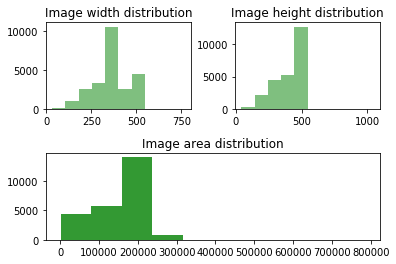

In [3]:
import matplotlib.pyplot as plt

# plot image height, width, area distribution
plt.subplot(221)
plt.hist(train_image_shapes[:,0], alpha=0.5, color=['green'])
plt.title('Image width distribution')

plt.subplot(222)
plt.hist(train_image_shapes[:,1], alpha=0.5, color=['green'])
plt.title('Image height distribution')

plt.subplot(212)
plt.hist(train_image_sizes, alpha=0.8, color=['green'])
plt.title('Image area distribution')

# 调整子图间距
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

### 图片预处理

1. 图片编码处理，转换为灰度图
2. 图片大小调整，缩放至适当大小
3. 随机对图片进行翻转、色彩处理
4. 将训练集分割为训练集和验证集

使用 opencv 结合 ImageDataGenerator 工具进行图片预处理。首先将图片 resized 到 299x299大小，然后对对图像实现归一化处理，将每张图像的像素值除以255，缩放到 0～1 之间。随后进行数据增强：随机左右、上下翻转，翻转，随机旋转一定角度。

In [4]:
from keras.preprocessing import image                  
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

target_image_size = (299, 299)
batch_size = 16

X = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR), #立方差值
                         target_image_size,
                         interpolation=cv2.INTER_CUBIC)
              for path in train_files])
Y = np.array([1 if 'dog' in path else 0 for path in train_files]) # for  sigmoid
#Y = train_targets # for softmax

In [5]:
print(X.shape, Y.shape)

(25000, 299, 299, 3) (25000,)


### 划分数据集

将初始训练集按照 9:1 的比例拆分为训练集、验证集。  
注：开始是按 7:3 的比例拆分，结果在验证集上的泛化能力并不好，没有达到预期目标；后来调整到 4:1, 有些许改善，最后调整为 9:1。

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# random_state设置为0, 取保每次分割都一样
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1, random_state=0)

# shuffle the train set
X_train, Y_train = shuffle(X_train, Y_train)

print("The size of train set: {}, validation set: {}".format(len(X_train), len(X_validation)))

The size of train set: 22500, validation set: 2500


In [7]:
datagen = ImageDataGenerator(rescale=1.0/255,      #像素值正则化0～1
                             shear_range=0.2,      #随机剪切变换强度
                             zoom_range=0.2,       #随机缩放幅度
                             rotation_range=45,    #随机旋转角度范围
                             horizontal_flip=True, #随机左右翻转
                             vertical_flip=True)   #随机上下翻转

train_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)
validation_generator = datagen.flow(X_validation, Y_validation, batch_size=batch_size)

### 数据预处理
####  获取模型的特征向量

提取 Xception 模型中与训练、测试与验证集相对应的 bottleneck 特征。

---
<a id='step1'></a>
## 步骤1：搭建模型

现在使用迁移学习来建立一个CNN，从而可以从图像中区别出猫还是狗。这里选取 Keras 提供的几个预训练的模型中比较新且参数数量比较小的 Xception 模型，并使用其在 imagenet 上的预训练权重，使用迁移学习的方法搭建CNN。

为了适合本项目猫狗的二分类，将Xception模型的输出层改为二分类的全连接。


In [8]:
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model

base_model = Xception(include_top=False, weights='imagenet')

m = base_model.output
m = GlobalAveragePooling2D(name='avg_pool')(m)
m = Dropout(0.5)(m)
#m = Dense(2, activation='softmax')(m)
m = Dense(1, activation='sigmoid')(m)

model = Model(inputs=base_model.input, outputs=m)

---
<a id='step2'></a>
## 步骤2：训练模型与评估


In [10]:
## 编译模型
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

#### 训练模型。

为防止过拟合，val_loss 不再下降后的 5 个 epochs 后停止训练

In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

epochs = 50
batch_size = 16

earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath='weights.best.xception.hdf5', verbose=1, save_best_only=True)
callback_list = [checkpointer, earlyStopping]

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_data=validation_generator, 
    
    validation_steps=len(X_validation) // batch_size
)

print(history.history.keys())

fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')

fig.savefig('performance.png')

Epoch 1/50
1406/1406 [==============================] - 455s 323ms/step - loss: 0.1316 - acc: 0.9510 - val_loss: 0.1915 - val_acc: 0.9388

Epoch 00001: val_loss improved from inf to 0.19146, saving model to weights.best.xception.hdf5
Epoch 2/50
1406/1406 [==============================] - 445s 316ms/step - loss: 0.0819 - acc: 0.9704 - val_loss: 0.1392 - val_acc: 0.9500

Epoch 00002: val_loss improved from 0.19146 to 0.13921, saving model to weights.best.xception.hdf5
Epoch 3/50
1406/1406 [==============================] - 442s 315ms/step - loss: 0.0729 - acc: 0.9747 - val_loss: 0.0590 - val_acc: 0.9800

Epoch 00003: val_loss improved from 0.13921 to 0.05903, saving model to weights.best.xception.hdf5
Epoch 4/50
1406/1406 [==============================] - 445s 316ms/step - loss: 0.0589 - acc: 0.9785 - val_loss: 0.0610 - val_acc: 0.9760

Epoch 00004: val_loss did not improve from 0.05903
Epoch 5/50
1406/1406 [==============================] - 444s 316ms/step - loss: 0.0551 - acc: 0.9793

In [12]:
with open('xception.json', 'w') as f:
    f.write(model.to_json())

---
<a id='step3'></a>
## 步骤 3: 模型预测



这里从别处借鉴了小技巧，将每个预测值限制到了 [0.005, 0.995] 的区间内。因为 kaggle 官方的评估标准是 LogLoss：
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$  
对于预测正确的样本，0.995 和 1 相差无几，但是对于预测错误的样本，0 和 0.005 的差距非常大，相当于 15 和 2 的差别。

上面训练过程中保存了最佳的权重，将模型的架构保存为 json 文件。因此后续预测的时候，只需要从 json 加载模型，并 load 权重即可。

In [13]:
from tqdm import tqdm
from keras.models import model_from_json

with open('xception.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('weights.best.xception.hdf5')

def load_test_image(index):
    img = cv2.imread('data/test/%d.jpg' % index)
    img = cv2.resize(img, target_image_size)
    img.astype(np.float32)
    img = img / 255.0
    return img

test_num = len(test_files)
T = np.zeros((test_num, 299, 299, 3), dtype=np.float32)

for i in tqdm(range(test_num)):
    T[i] = load_test_image(i + 1)

predictions = model.predict(T, verbose=1)
predictions_clip = predictions.clip(min=0.005, max=0.995)

csv_content = 'id,label\n'

for idx, prob in tqdm(enumerate(predictions_clip)):
    csv_content += '%d,%f\n' % (idx + 1, prob)

with open('KerasResultUsingXceptionNotop.csv', 'w') as f:
    f.write(csv_content)

100%|██████████| 12500/12500 [00:53<00:00, 234.37it/s]


12500/12500 [==============================] - 77s 6ms/step


12500it [00:00, 548051.51it/s]


---
<a id='step4'></a>
## 步骤4：模型可视化

Using TensorFlow backend.


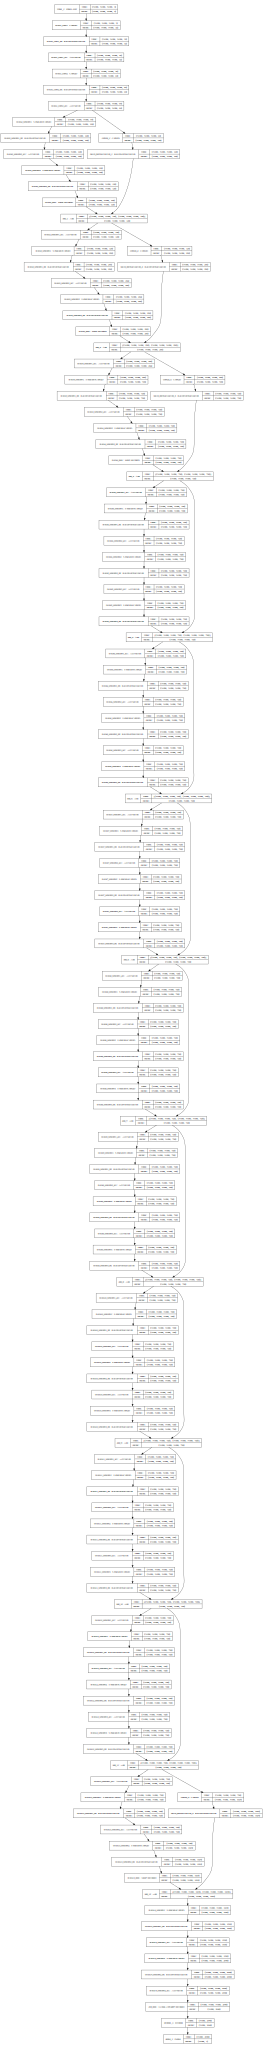

In [1]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import model_from_json
from keras.utils import plot_model

with open('xception.json', 'r') as f:
    model = model_from_json(f.read())

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 将模型结构保存为图片：
plot_model(model, to_file='model.png')

## 参考文献  
1. [深度学习——分类之Xception和卷积的分组](https://zhuanlan.zhihu.com/p/32965380)
2. [手把手教你如何在Kaggle猫狗大战冲到Top2%](https://zhuanlan.zhihu.com/p/25978105)
3. [Keras Image Data Augmentation 各参数详解](https://zhuanlan.zhihu.com/p/30197320)